In [1]:
# ==== Imports ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ==== Load Dataset ====
df = pd.read_excel("AI_Inventory_Management_Dataset_2000.xlsx", sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# ==== Preprocessing ====
features = ['Stock_Level', 'Supplier_Lead_Time', 'Price_Per_Unit', 'Promotion', 'Day_of_Week', 'Holiday', 'Weather_Index']
target = 'Sales'
X = df[features]
y = df[target]

numeric_features = ['Stock_Level', 'Supplier_Lead_Time', 'Price_Per_Unit', 'Weather_Index']
categorical_features = ['Promotion', 'Day_of_Week', 'Holiday']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ==== Forecasting Model ====
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# ==== Model Evaluation ====
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest MAPE: {mape:.2%}")


Random Forest RMSE: 24.63
Random Forest MAPE: 44.99%


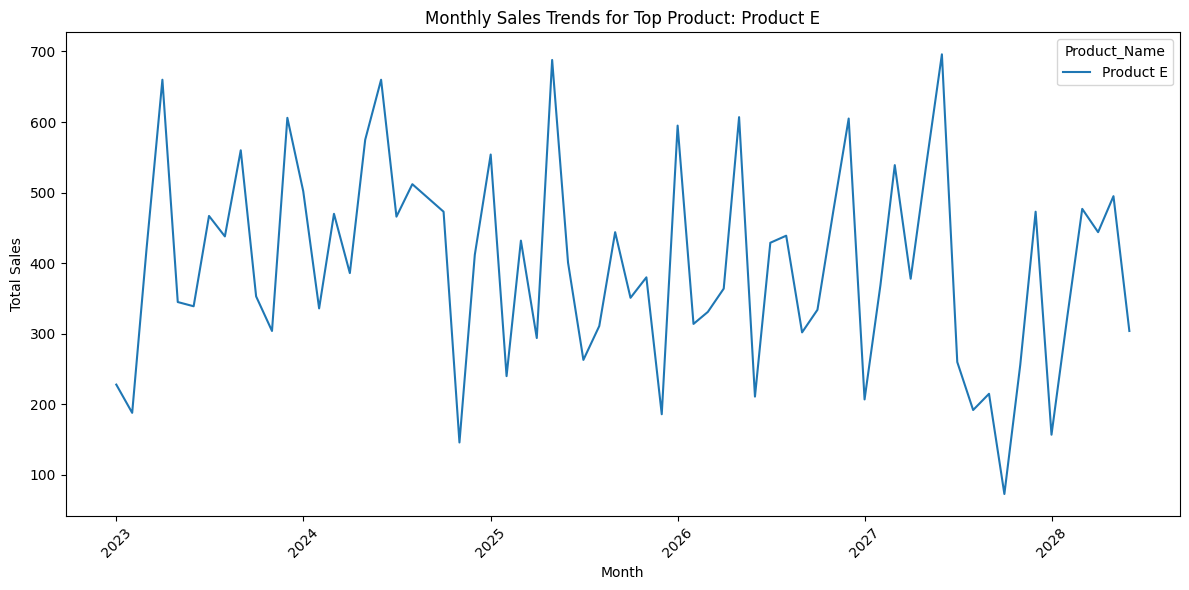

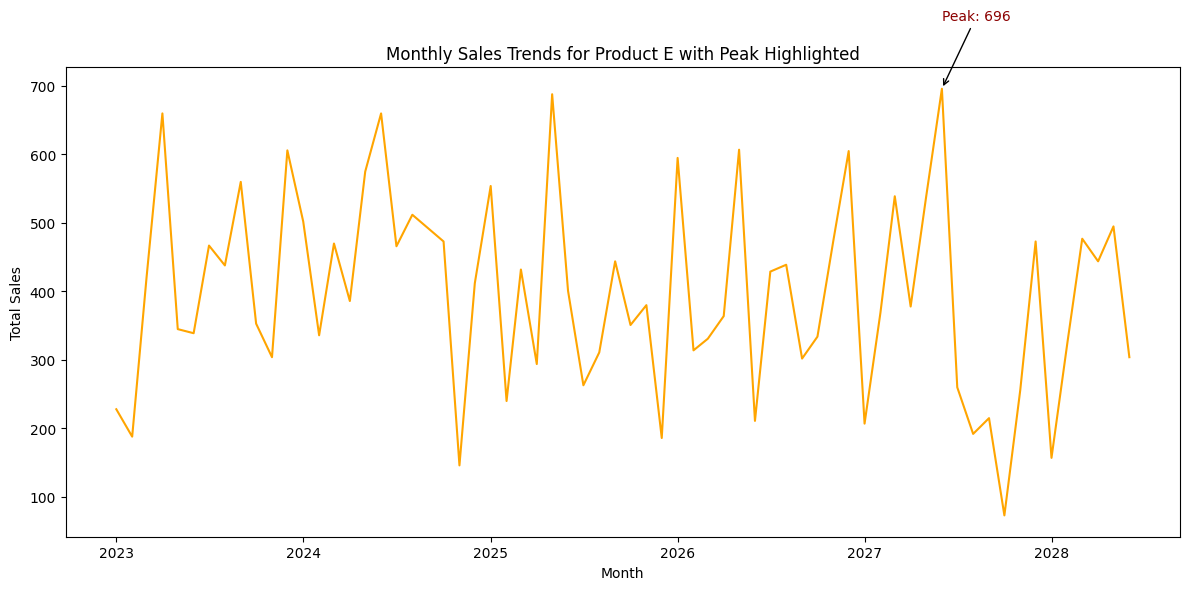

In [2]:
# ==== Visualizations ====
df['Month'] = df['Date'].dt.to_period('M')
top_product = df.groupby('Product_Name')['Sales'].sum().idxmax()
monthly_sales = df[df['Product_Name'] == top_product].groupby(['Month', 'Product_Name'])['Sales'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', hue='Product_Name')
plt.title(f'Monthly Sales Trends for Top Product: {top_product}')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Top_Product_Monthly_Sales.png")
plt.show()

peak = monthly_sales.loc[monthly_sales['Sales'].idxmax()]
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', color='orange')
plt.title(f'Monthly Sales Trends for {top_product} with Peak Highlighted')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.annotate(
    f"Peak: {int(peak['Sales'])}",
    xy=(peak['Month'], peak['Sales']),
    xytext=(peak['Month'], peak['Sales'] + 100),
    arrowprops=dict(facecolor='red', arrowstyle='->'),
    fontsize=10,
    color='darkred'
)
plt.tight_layout()
plt.savefig("Top_Product_Monthly_Sales_Annotated.png")
plt.show()


In [3]:
# ==== VAE Implementation ====
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class VAEDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# ==== Train the VAE ====
vae_features = df[numeric_features].values
vae_dataset = VAEDataset(vae_features)
vae_loader = DataLoader(vae_dataset, batch_size=64, shuffle=True)

vae = VAE(input_dim=vae_features.shape[1])
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

vae.train()
for epoch in range(10):
    total_loss = 0
    for batch in vae_loader:
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.2f}")

Epoch 1, Loss: 1100640614129515045457254940672.00
Epoch 2, Loss: 1100640658586168263097274335232.00
Epoch 3, Loss: 1100640665369958396203961942016.00
Epoch 4, Loss: 1100640672536518468840122744832.00
Epoch 5, Loss: 1100640674175972848391059144704.00
Epoch 6, Loss: 1100640641375356042326262677504.00
Epoch 7, Loss: 1100640582756215062095735029760.00
Epoch 8, Loss: 1100640631593969997241772933120.00
Epoch 9, Loss: 1100640694912419030249808855040.00
Epoch 10, Loss: 1100640611768331804022432333824.00


<ipython-input-5-7d0ca5e3383e>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inventory_turnover = df.groupby('Product_Name').apply(
<ipython-input-5-7d0ca5e3383e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=inventory_turnover, x='Product_Name', y='Inventory_Turnover', palette='viridis')


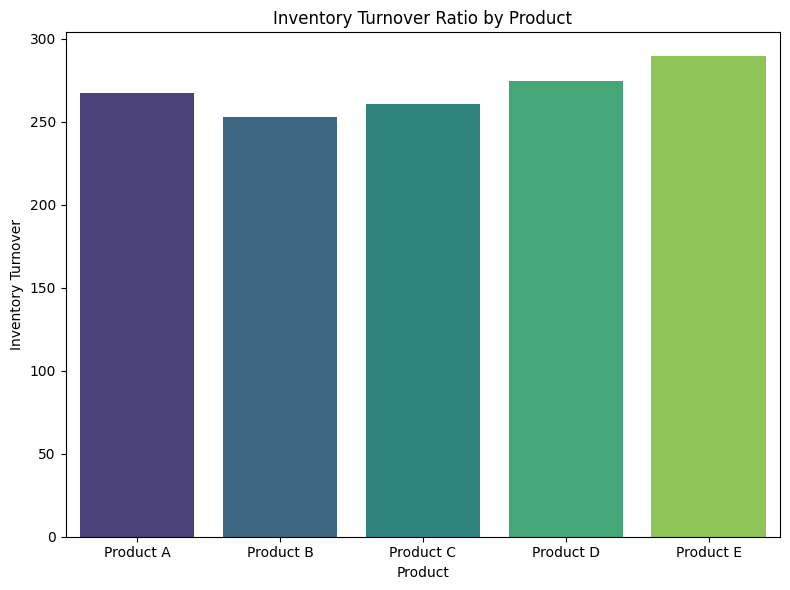

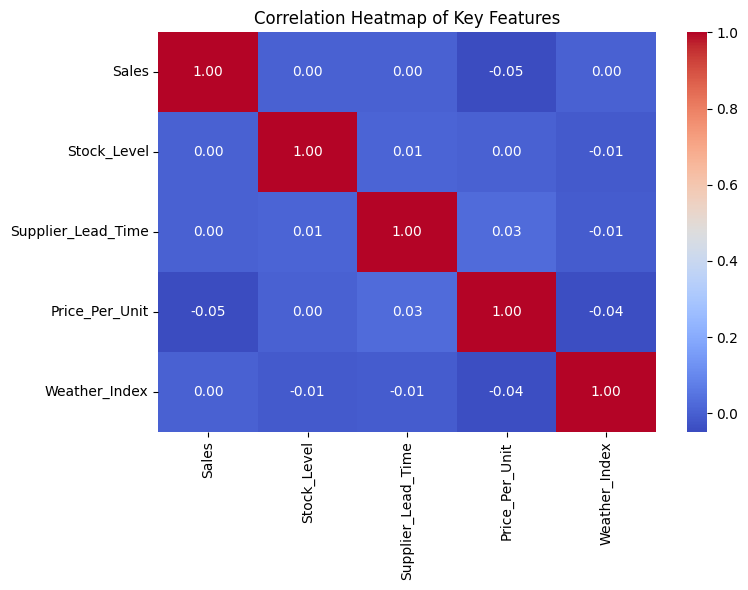

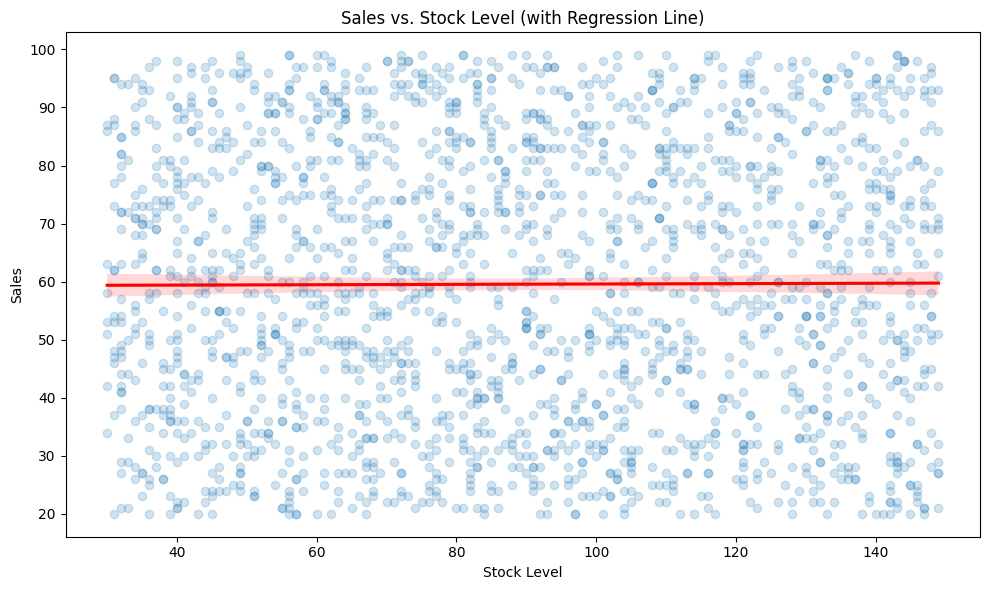

In [5]:
# === Additional Visualizations ===

# 1. Inventory Turnover Ratio by Product
inventory_turnover = df.groupby('Product_Name').apply(
    lambda x: x['Sales'].sum() / x['Stock_Level'].mean()
).reset_index(name='Inventory_Turnover')

plt.figure(figsize=(8, 6))
sns.barplot(data=inventory_turnover, x='Product_Name', y='Inventory_Turnover', palette='viridis')
plt.title('Inventory Turnover Ratio by Product')
plt.xlabel('Product')
plt.ylabel('Inventory Turnover')
plt.tight_layout()
plt.savefig("Inventory_Turnover_by_Product.png")
plt.show()

# 2. Correlation Heatmap
corr = df[['Sales', 'Stock_Level', 'Supplier_Lead_Time', 'Price_Per_Unit', 'Weather_Index']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.savefig("Correlation_Heatmap.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Stock_Level', y='Sales', scatter_kws={'alpha':0.2}, line_kws={'color': 'red'})
plt.title('Sales vs. Stock Level (with Regression Line)')
plt.xlabel('Stock Level')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()


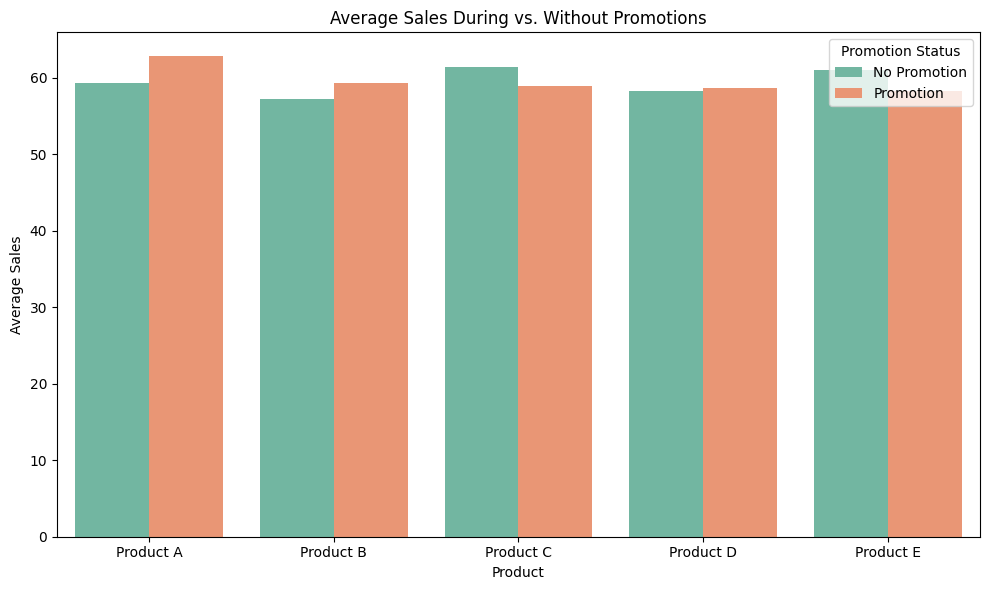

In [6]:
# Promotion Impact: Average Sales Before vs. During Promotions
promo_impact = df.groupby(['Product_Name', 'Promotion'])['Sales'].mean().reset_index()
promo_impact['Promotion'] = promo_impact['Promotion'].map({0: 'No Promotion', 1: 'Promotion'})

plt.figure(figsize=(10, 6))
sns.barplot(data=promo_impact, x='Product_Name', y='Sales', hue='Promotion', palette='Set2')
plt.title('Average Sales During vs. Without Promotions')
plt.xlabel('Product')
plt.ylabel('Average Sales')
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.savefig("Sales_Promotion_Impact.png")
plt.show()


In [8]:
# ==== Generate Synthetic Samples from VAE ====
vae.eval()
with torch.no_grad():
    z = torch.randn(100, 32)  # 100 samples from latent space (latent_dim = 32)
    synthetic_data = vae.decoder(z).numpy()

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=numeric_features)

# Save to CSV
synthetic_df.to_csv("vae_synthetic_samples.csv", index=False)
print("✅ VAE synthetic samples saved as vae_synthetic_samples.csv")


✅ VAE synthetic samples saved as vae_synthetic_samples.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>